In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir("drive/My Drive/Google_Colab_Drive/DCGAN_Projects_TF2.X/Understanding_Deepfakes")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# Understanding Deepfakes

![DCGAN](DCGAN.png)

# Task 1: Importing Libraries and Helper Functions

In [1]:
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


# Task 2: Importing and Plotting the Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0
x_train_index_0 = np.argwhere(y_train == 0)
x_train_subset = x_train[x_train_index_0]
x_test_index_0 = np.argwhere(y_test == 0)
x_test_subset = x_test[x_test_index_0]
x = np.concatenate([x_train_subset, x_test_subset], axis = 0)
x = np.squeeze(x)
print (x.shape)

11493376/11490434 [==============================] - 0s 0us/step
(6903, 28, 28)


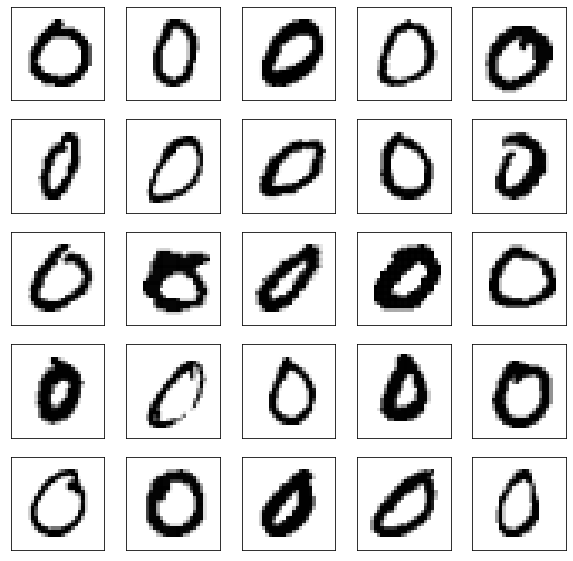

In [4]:
plt.figure(figsize=(10,10))
randIndex = np.random.randint(0, len(x), 25)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[randIndex[i]].reshape((28,28)), cmap=plt.cm.binary)
plt.show()

# Task 3: Discriminator

![Artist and Critic](artist_critic.png)

In [5]:
discminator_model = tf.keras.Sequential([
    Conv2D(64, 3, strides=(2,2), input_shape = (28, 28, 1)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=(2,2)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256, 5, strides=(2,2)),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)
discminator_model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
discminator_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 256)         8

# Task 4: Generator

In [6]:
generator_model = Sequential([
    Dense(256, activation='relu', input_shape = (1, )),
    Reshape((1,1,256)),
    
    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(64, 5, strides=(2,2), activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(32, 5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(1, 4, activation='sigmoid')
])

generator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)       

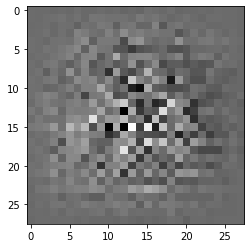

In [7]:
noise = np.random.randn(1,1)
gen_image = generator_model.predict(noise)[0]
gen_image = np.squeeze(gen_image)
plt.figure(figsize=(4,4))
plt.imshow(gen_image, cmap=plt.cm.binary)
plt.show()

# Task 5: Generative Adversarial Network (GAN)

In [8]:
input_layer = tf.keras.layers.Input(shape=(1,))
gen_out = generator_model(input_layer)
dis_out = discminator_model(gen_out)

gan = Model(
    inputs= input_layer,
    outputs = dis_out)
# We have to set discminator_model to not trainable.
# When we make the 1st pass through the GAN we don't want discriminator to be trainable. 
# For every iteration we have to switch the discminator_model parameters from not-Trainable to Trainable
# and vice-versa to make sure while the generator_model is getting trained we don't want discminator_model 
# to get trained. 
discminator_model.trainable = False 
gan.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

In [9]:
epochs = 100
batch_size = 128

steps_each_epoch = int (2 * x.shape[0]/batch_size)
print (steps_each_epoch)

107


In [10]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [12]:
from IPython import display
seed = tf.random.normal(shape=[4, 1])

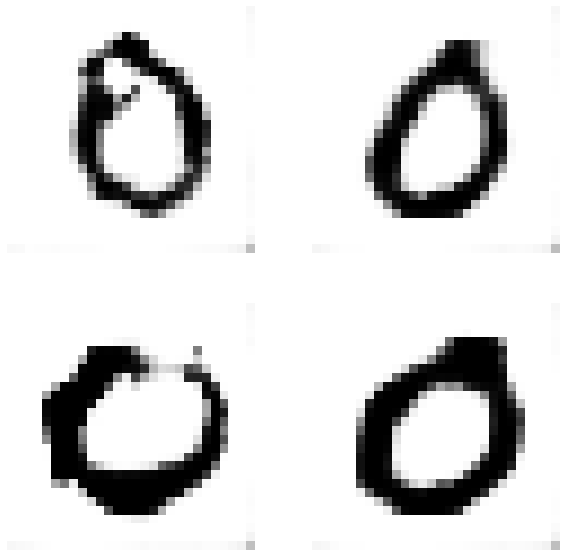

In [13]:
# The fake images will have y values 0 associated with them and
# true images will have y values 1 associated with them
# We will train the discriminator on the combination of true and fake images
# and the correct y values associated with them. Then, 
# When we are training the GAN we are not training discriminator (because y values would not be the ideal). 
# We only want generator to get trained by then. In this pass we are only using the fake images with y label 1.

for e in tqdm(range(epochs)):
    print("Epochs: {}/{}".format(e+1, epochs))
    for step in range(steps_each_epoch):
        true_examples = x[int(batch_size/2)*step:int(batch_size/2)*(step+1)]
        true_examples = np.expand_dims(true_examples, axis = -1)
        noise = np.random.randn(int(batch_size/2), 1)
        gen_examples = generator_model.predict(noise)
        
        x_batch = np.concatenate([gen_examples, true_examples], axis = 0)
        y_batch = np.array([0]*int(batch_size/2) + [1]*int(batch_size/2))
        
        indices = np.random.choice(range(batch_size), batch_size, replace = True)
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        
        discminator_model.trainable = True
        discminator_model.train_on_batch(x_batch, y_batch)
        discminator_model.trainable = False
        
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))
        _, acc = discminator_model.evaluate(x_batch, y_batch, verbose = False) # discminator_model accuracy should reduce
    display.clear_output(wait = True)
    generate_and_save_images(generator_model, e+1, seed)
        
display.clear_output(wait = True)
generate_and_save_images(generator_model, epochs, seed)
        

In [2]:
import imageio
import glob

anim_file = 'deepfake.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


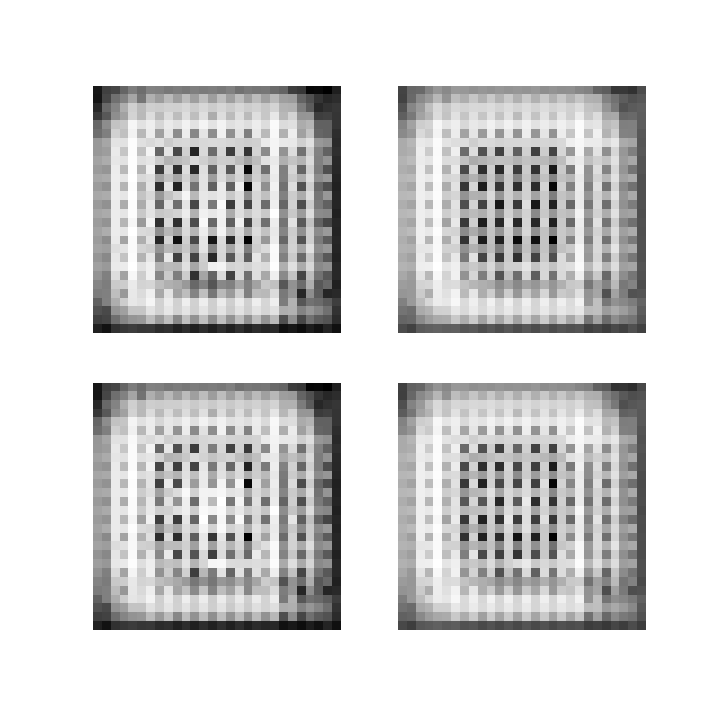

In [4]:
import IPython
IPython.display.Image(filename=anim_file)